# climate invariant

see: (https://colab.research.google.com/github/tbeucler/CBRAIN-CAM/blob/master/Climate_Invariant_Guide.ipynb#scrollTo=2lRDZ4uVxLRz)


In [2]:
%cd /kaggle/working

import os

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path="../experiments/091_cloud_wather_then_q23"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=["exp=base_all", "debug=True"],
        return_hydra_config=True,
    )

/kaggle/working


In [7]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(100)

polars.config.Config

In [8]:
df = pl.read_parquet("input/train.parquet", n_rows=10000)
df = df[:, 1:]  # id を抜く

In [15]:
import xarray as xr

grid_path = "/kaggle/working/misc/grid_info/ClimSim_low-res_grid-info.nc"
grid_info = xr.open_dataset(grid_path)
hyam = grid_info["hyam"].to_numpy()
hybm = grid_info["hybm"].to_numpy()
hyai = grid_info["hyai"].to_numpy()
hybi = grid_info["hybi"].to_numpy()

P0 = 1e5

## relative humidity

In [93]:
import numpy as np


def eliq(T, method="paper"):
    """
    Function taking temperature (in K) and outputting liquid saturation
    pressure (in hPa) using a polynomial fit
    """
    if method == "paper":
        a_liq = np.array(
            [
                -0.976195544e-15,
                -0.952447341e-13,
                0.640689451e-10,
                0.206739458e-7,
                0.302950461e-5,
                0.264847430e-3,
                0.142986287e-1,
                0.443987641,
                6.11239921,
            ]
        )
        c_liq = -80
        T0 = 273.16
        return 100 * np.polyval(a_liq, np.maximum(c_liq, T - T0))

    elif method == "e3sm":
        a0 = 6.105851
        a1 = 0.4440316
        a2 = 0.1430341e-1
        a3 = 0.2641412e-3
        a4 = 0.2995057e-5
        a5 = 0.2031998e-7
        a6 = 0.6936113e-10
        a7 = 0.2564861e-13
        a8 = -0.3704404e-15

        dtt = T - 273.16
        esatw = a0 + dtt * (
            a1
            + dtt
            * (
                a2
                + dtt
                * (a3 + dtt * (a4 + dtt * (a5 + dtt * (a6 + dtt * (a7 + a8 * dtt)))))
            )
        )

        index = dtt <= -80.0
        esatw[index] = (
            2.0
            * 0.01
            * np.exp(9.550426 - 5723.265 / T + 3.53068 * np.log(T) - 0.00728332 * T)
        )[index]
        return esatw * (10**2)
    elif method == "tenten":
        # https://metview.readthedocs.io/en/latest/api/functions/saturation_vapour_pressure.html
        a1 = 611.21
        a3 = 17.502
        a4 = 32.19
        return a1 * np.exp(a3 * (T - 273.16) / (T - a4))


def eice(T, method="paper"):
    """
    Function taking temperature (in K) and outputting ice saturation
    pressure (in hPa) using a polynomial fit
    """
    if method == "paper":
        a_ice = np.array(
            [
                0.252751365e-14,
                0.146898966e-11,
                0.385852041e-9,
                0.602588177e-7,
                0.615021634e-5,
                0.420895665e-3,
                0.188439774e-1,
                0.503160820,
                6.11147274,
            ]
        )
        c_ice = np.array([273.15, 185, -100, 0.00763685, 0.000151069, 7.48215e-07])
        T0 = 273.16
        return (
            (T > c_ice[0]) * eliq(T)
            + (T <= c_ice[0]) * (T > c_ice[1]) * 100 * np.polyval(a_ice, T - T0)
            + (T <= c_ice[1])
            * 100
            * (
                c_ice[3]
                + np.maximum(c_ice[2], T - T0)
                * (c_ice[4] + np.maximum(c_ice[2], T - T0) * c_ice[5])
            )
        )
    elif method == "e3sm":
        a0 = 6.11147274
        a1 = 0.503160820
        a2 = 0.188439774e-1
        a3 = 0.420895665e-3
        a4 = 0.615021634e-5
        a5 = 0.602588177e-7
        a6 = 0.385852041e-9
        a7 = 0.146898966e-11
        a8 = 0.252751365e-14

        dtt = T - 273.16
        esati = a0 + dtt * (
            a1
            + dtt
            * (
                a2
                + dtt
                * (a3 + dtt * (a4 + dtt * (a5 + dtt * (a6 + dtt * (a7 + a8 * dtt)))))
            )
        )

        index = dtt <= -80.0
        esati[index] = (
            0.01
            * np.exp(9.550426 - 5723.265 / T + 3.53068 * np.log(T) - 0.00728332 * T)
        )[index]
        return esati * (10**2)

    elif method == "tenten":
        # https://metview.readthedocs.io/en/latest/api/functions/saturation_vapour_pressure.html
        a1 = 611.21
        a3 = 22.587
        a4 = -0.7
        return a1 * np.exp(a3 * (T - 273.16) / (T - a4))

In [94]:
t = np.array([178.61875689])
eliq(t), eice(t), eliq(t, "e3sm"), eice(t, "e3sm"), eliq(t, "tenten"), eice(t, "tenten")

(array([0.17827185]),
 array([0.00421795]),
 array([0.00829847]),
 array([0.00414923]),
 array([0.00756163]),
 array([0.00411556]))

In [95]:
def cal_specific2relative_coef(
    temperature_array,
    near_surface_air_pressure,
    hyam,
    hybm,
    method="paper",
):
    """
    specific humidity を relative humidity に変換するための係数を算出する（逆数を取れば逆変換にも使える）
    """
    P0 = 1e5  # Mean surface air pressure (Pa)
    # Formula to calculate air pressure (in Pa) using the hybrid vertical grid
    # coefficients at the middle of each vertical level: hyam and hybm
    air_pressure_Pa = hyam * P0 + hybm[None, :] * near_surface_air_pressure[:, None]

    # 1) Calculating saturation water vapor pressure
    T0 = 273.16  # Freezing temperature in standard conditions
    T00 = 253.16  # Temperature below which we use e_ice
    omega = (temperature_array - T00) / (T0 - T00)
    omega = np.maximum(0, np.minimum(1, omega))

    esat = omega * eliq(temperature_array, method) + (1 - omega) * eice(
        temperature_array, method
    )
    # 2) Calculating relative humidity
    Rd = 287  # Specific gas constant for dry air
    Rv = 461  # Specific gas constant for water vapor

    # We use the `values` method to convert Xarray DataArray into Numpy ND-Arrays
    return Rv / Rd * air_pressure_Pa / esat

In [96]:
temperature_array = df[:, :60].to_numpy()
specific_humidity_array = df[:, 60:120].to_numpy()
near_surface_air_pressure = df[:, 360].to_numpy()
near_surface_air_pressure[0]

101135.6163329346

In [97]:
specific2relative_coef = cal_specific2relative_coef(
    temperature_array,
    near_surface_air_pressure,
    hyam,
    hybm,
)

relative_humidity = specific2relative_coef * specific_humidity_array

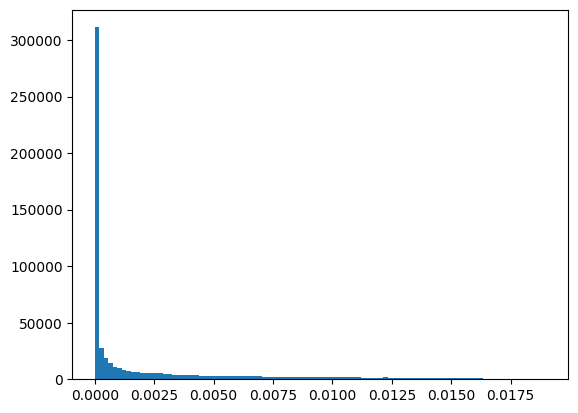

In [98]:
plt.hist(specific_humidity_array.flatten(), bins=100)
plt.show()

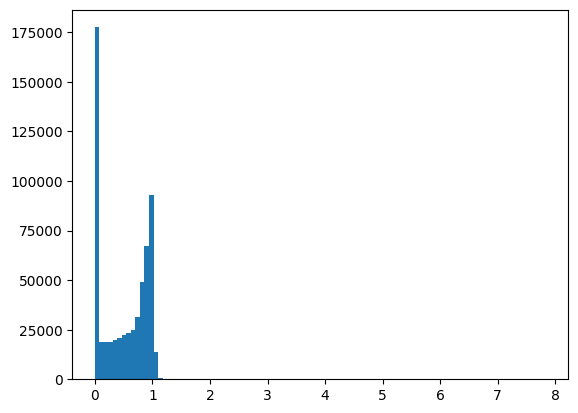

In [99]:
plt.hist(relative_humidity.flatten(), bins=100)
plt.show()

In [58]:
relative_humidity[relative_humidity > 3]

array([5.36684856, 5.04147533, 3.63954417, 3.19565073, 4.59619028,
       7.8351823 , 6.70890873])

In [59]:
temperature_array[relative_humidity > 3]

array([178.61875689, 187.11101102, 177.7739451 , 187.11493334,
       182.29315816, 187.5466503 , 185.24974843])

In [60]:
specific_humidity_array[relative_humidity > 3]

array([1.48926733e-06, 5.80588255e-06, 8.28654242e-07, 3.68313081e-06,
       2.64689077e-06, 9.83939429e-06, 5.01437613e-06])

In [61]:
near_surface_air_pressure[np.any(relative_humidity > 3, axis=1)]

array([ 99593.64047217,  99806.14235389, 100697.01071881, 100097.30839393])

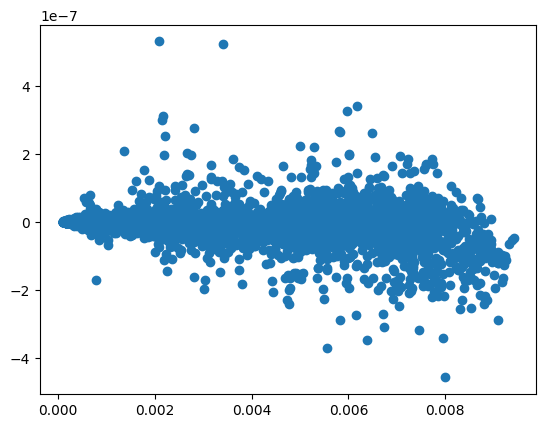

In [115]:
h = 40
plt.scatter(specific_humidity_array[:, h], df[:, 556 + 60 + h].to_numpy())
plt.show()

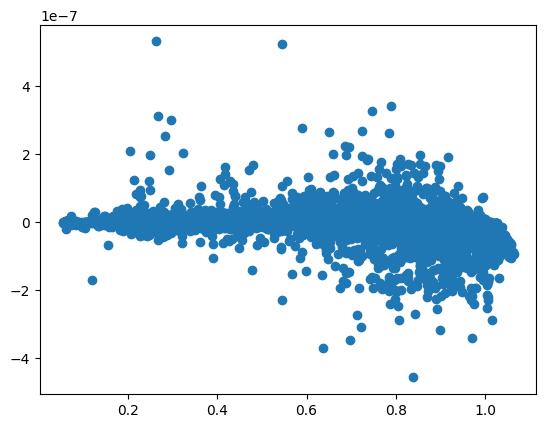

In [116]:
h = 40
plt.scatter(relative_humidity[:, h], df[:, 556 + 60 + h].to_numpy())
plt.show()

## 共通

In [107]:
import scipy.integrate as sin

L_V = 2.501e6  # Latent heat of vaporization
L_I = 3.337e5  # Latent heat of freezing
L_F = L_I
L_S = L_V + L_I  # Sublimation
C_P = 1.00464e3  # Specific heat capacity of air at constant pressure
G = 9.80616
RHO_L = 1e3


class ThermLibNumpy:
    @staticmethod
    def eliqNumpy(T):
        a_liq = np.float32(
            np.array(
                [
                    -0.976195544e-15,
                    -0.952447341e-13,
                    0.640689451e-10,
                    0.206739458e-7,
                    0.302950461e-5,
                    0.264847430e-3,
                    0.142986287e-1,
                    0.443987641,
                    6.11239921,
                ]
            )
        )
        c_liq = np.float32(-80.0)
        T0 = np.float32(273.16)
        return np.float32(100.0) * np.polyval(a_liq, np.maximum(c_liq, T - T0))

    @staticmethod
    def eiceNumpy(T):
        a_ice = np.float32(
            np.array(
                [
                    0.252751365e-14,
                    0.146898966e-11,
                    0.385852041e-9,
                    0.602588177e-7,
                    0.615021634e-5,
                    0.420895665e-3,
                    0.188439774e-1,
                    0.503160820,
                    6.11147274,
                ]
            )
        )
        c_ice = np.float32(
            np.array([273.15, 185, -100, 0.00763685, 0.000151069, 7.48215e-07])
        )
        T0 = np.float32(273.16)
        return np.where(
            T > c_ice[0],
            ThermLibNumpy.eliqNumpy(T),
            np.where(
                T <= c_ice[1],
                np.float32(100.0)
                * (
                    c_ice[3]
                    + np.maximum(c_ice[2], T - T0)
                    * (c_ice[4] + np.maximum(c_ice[2], T - T0) * c_ice[5])
                ),
                np.float32(100.0) * np.polyval(a_ice, T - T0),
            ),
        )

    @staticmethod
    def esatNumpy(T):
        T0 = np.float32(273.16)
        T00 = np.float32(253.16)
        omtmp = (T - T00) / (T0 - T00)
        omega = np.maximum(np.float32(0.0), np.minimum(np.float32(1.0), omtmp))

        return np.where(
            T > T0,
            ThermLibNumpy.eliqNumpy(T),
            np.where(
                T < T00,
                ThermLibNumpy.eiceNumpy(T),
                (
                    omega * ThermLibNumpy.eliqNumpy(T)
                    + (1 - omega) * ThermLibNumpy.eiceNumpy(T)
                ),
            ),
        )

    @staticmethod
    def qvNumpy(T, RH, P0, PS, hyam, hybm):

        R = np.float32(287.0)
        Rv = np.float32(461.0)
        p = P0 * hyam + PS[:, None] * hybm  # Total pressure (Pa)

        T = T.astype(np.float32)
        if type(RH) == int:
            RH = T**0
        RH = RH.astype(np.float32)
        p = p.astype(np.float32)

        return R * ThermLibNumpy.esatNumpy(T) * RH / (Rv * p)

    @staticmethod
    def RHNumpy(T, qv, P0, PS, hyam, hybm):
        R = np.float32(287.0)
        Rv = np.float32(461.0)
        p = P0 * hyam + PS[:, None] * hybm  # Total pressure (Pa)

        T = T.astype(np.float32)
        qv = qv.astype(np.float32)
        p = p.astype(np.float32)

        return Rv * p * qv / (R * ThermLibNumpy.esatNumpy(T))

    @staticmethod
    def qsatNumpy(T, P0, PS, hyam, hybm):
        return ThermLibNumpy.qvNumpy(T, 1, P0, PS, hyam, hybm)

    @staticmethod
    def qsatsurfNumpy(TS, P0, PS):
        R = 287
        Rv = 461
        return R * ThermLibNumpy.esatNumpy(TS) / (Rv * PS)

    @staticmethod
    def dPNumpy(PS):
        S = PS.shape
        P = 1e5 * np.tile(hyai, (S[0], 1)) + np.transpose(
            np.tile(PS, (61, 1))
        ) * np.tile(hybi, (S[0], 1))
        return P[:, 1:] - P[:, :-1]

    @staticmethod
    def theta_e_calc(T, qv, P0, PS, hyam, hybm):
        S = PS.shape
        p = P0 * np.tile(hyam, (S[0], 1)) + np.transpose(
            np.tile(PS, (60, 1))
        ) * np.tile(hybm, (S[0], 1))
        RV = 461.5
        RD = 287.04
        EPS = RD / RV
        r = qv / (1.0 - qv)
        # get ev in hPa
        ev_hPa = 100 * p * r / (EPS + r)
        # get TL
        TL = (2840.0 / ((3.5 * np.log(T)) - (np.log(ev_hPa)) - 4.805)) + 55.0
        # calc chi_e:
        chi_e = 0.2854 * (1.0 - (0.28 * r))
        P0_norm = P0 / (
            P0 * np.tile(hyam, (S[0], 1))
            + np.transpose(np.tile(PS, (60, 1))) * np.tile(hybm, (S[0], 1))
        )
        theta_e = (
            T
            * P0_norm**chi_e
            * np.exp(((3.376 / TL) - 0.00254) * r * 1000.0 * (1.0 + (0.81 * r)))
        )
        return theta_e

    @staticmethod
    def theta_e_sat_calc(T, P0, PS, hyam, hybm):
        return ThermLibNumpy.theta_e_calc(
            T, ThermLibNumpy.qsatNumpy(T, P0, PS, hyam, hybm), P0, PS, hyam, hybm
        )

    @staticmethod
    def bmse_calc(T, qv, P0, PS, hyam, hybm):
        eps = 0.622  # Ratio of molecular weight(H2O)/molecular weight(dry air)
        R_D = 287  # Specific gas constant of dry air in J/K/kg
        Rv = 461
        # Calculate kappa
        QSAT0 = ThermLibNumpy.qsatNumpy(T, P0, PS, hyam, hybm)
        kappa = 1 + (L_V**2) * QSAT0 / (Rv * C_P * (T**2))
        # Calculate geopotential
        r = qv / (qv**0 - qv)
        Tv = T * (r**0 + r / eps) / (r**0 + r)
        p = P0 * hyam + PS[:, None] * hybm
        p = p.astype(np.float32)
        RHO = p / (R_D * Tv)
        Z = -sin.cumtrapz(x=p, y=1 / (G * RHO), axis=1)
        Z = np.concatenate((0 * Z[:, 0:1] ** 0, Z), axis=1)
        # Assuming near-surface is at 2 meters
        Z = (Z - Z[:, [29]]) + 2
        # Calculate MSEs of plume and environment
        Tile_dim = [1, 60]
        h_plume = np.tile(
            np.expand_dims(C_P * T[:, -1] + L_V * qv[:, -1], axis=1), Tile_dim
        )
        h_satenv = C_P * T + L_V * qv + G * Z
        return (G / kappa) * (h_plume - h_satenv) / (C_P * T)

In [108]:
temperature_array = df[:, :60].to_numpy()
specific_humidity_array = df[:, 60:120].to_numpy()
near_surface_air_pressure = df[:, 360].to_numpy()
near_surface_air_pressure[0]

101135.6163329346

In [109]:
buoyancy = ThermLibNumpy.bmse_calc(
    temperature_array,
    specific_humidity_array,
    1e5,
    near_surface_air_pressure,
    hyam,
    hybm,
)

/tmp/ipykernel_305/1948320746.py:182: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  Z = -sin.cumtrapz(x=p, y=1 / (G * RHO), axis=1)


In [110]:
buoyancy

array([[-0.74424885, -0.44307541, -0.32656429, ...,  0.8765823 ,
         0.83986634,  0.80302051],
       [-0.82525327, -0.30225574, -0.32158267, ...,  0.99001068,
         0.95072559,  0.91086423],
       [-0.47880932, -0.52285272, -0.17618028, ...,  0.76446281,
         0.7310314 ,  0.69703333],
       ...,
       [-0.62780936, -0.26255454, -0.26784218, ...,  0.76630003,
         0.73458085,  0.70604111],
       [-0.51441598, -0.1467263 , -0.20665195, ...,  0.49812704,
         0.47452457,  0.44928917],
       [-0.52951761, -0.15806912, -0.17287916, ...,  0.6349072 ,
         0.60713349,  0.57914273]])

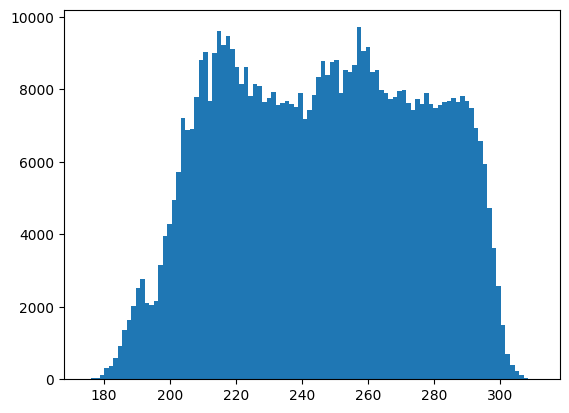

In [112]:
plt.hist(temperature_array.flatten(), bins=100)
plt.show()

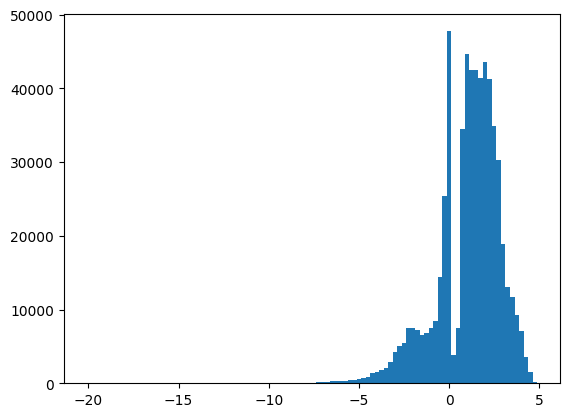

In [113]:
plt.hist(buoyancy.flatten(), bins=100)
plt.show()

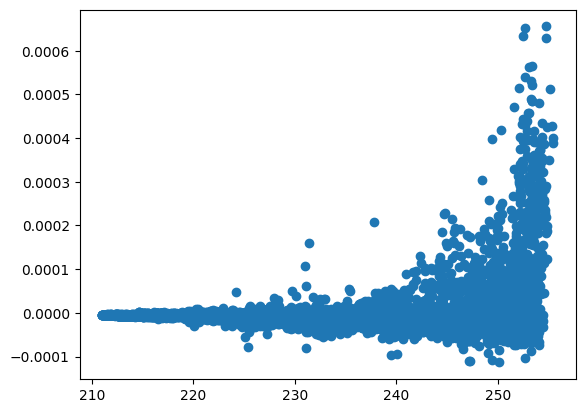

In [123]:
h = 30
plt.scatter(temperature_array[:, h], df[:, 556 + 0 + h].to_numpy())
plt.show()

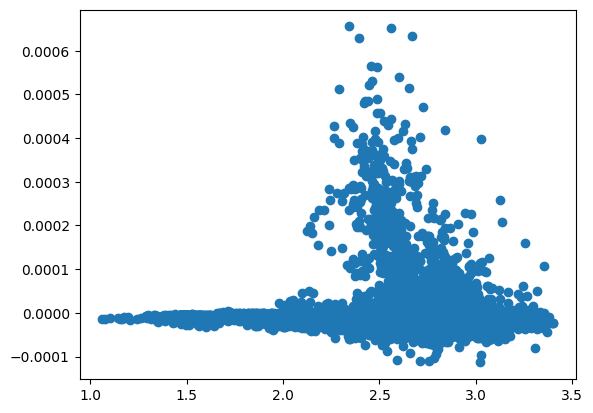

In [124]:
h = 30
plt.scatter(buoyancy[:, h], df[:, 556 + 0 + h].to_numpy())
plt.show()

## surface latent heat fluxes

In [128]:
# Surface latent heat fluxes to version of LHF normalized by
# near-surface temperature disequilibrium
def cal_normalized_lfh(qvprior, Tprior, PSprior, LHFprior, hyam, hybm, epsilon=1e-3):
    Qdenprior = (ThermLibNumpy.qsatNumpy(Tprior, P0, PSprior, hyam, hybm))[
        :, -1
    ] - qvprior[:, -1]
    Qdenprior = np.maximum(epsilon, Qdenprior)

    Tile_dim = [1, 1]
    # LHFtile = np.tile(np.expand_dims(LHFprior,axis=1),Tile_dim)
    LHFscaled = LHFprior / (L_V * Qdenprior)
    LHFtile = np.tile(np.expand_dims(LHFscaled.astype(np.float32), axis=1), Tile_dim)

    return LHFtile

In [129]:
temperature_array = df[:, :60].to_numpy()
specific_humidity_array = df[:, 60:120].to_numpy()
near_surface_air_pressure = df[:, 360].to_numpy()
surface_latent_heat_flux = df[:, 362].to_numpy()
surface_latent_heat_flux[0]

89.48877445566424

In [132]:
lhf = cal_normalized_lfh(
    specific_humidity_array,
    temperature_array,
    near_surface_air_pressure,
    surface_latent_heat_flux,
    hyam,
    hybm,
)

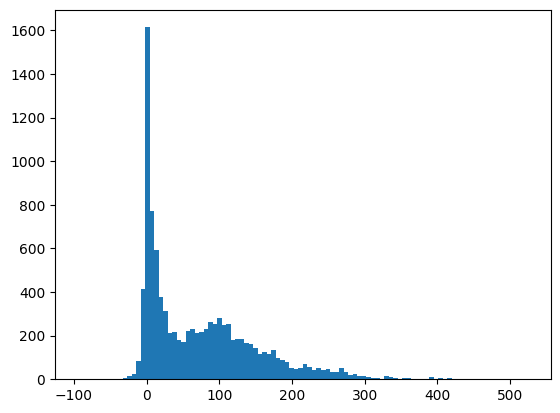

In [134]:
plt.hist(surface_latent_heat_flux.flatten(), bins=100)
plt.show()

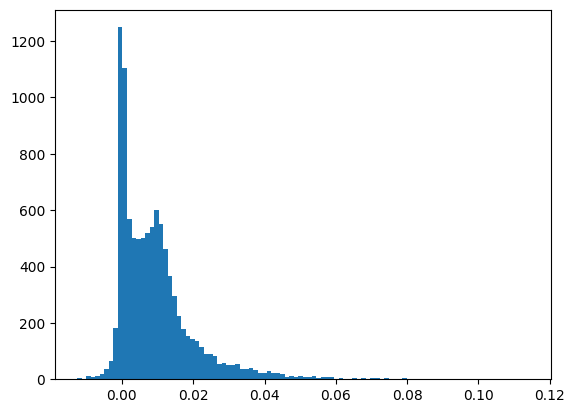

In [135]:
plt.hist(lhf.flatten(), bins=100)
plt.show()